In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

import pandas as pd
import torch
from torch.utils.data import DataLoader


In [2]:
data = pd.read_csv(
    "../data/processed/ml_dataset.csv",
    index_col=0,
    parse_dates=True
)

X = data.drop(columns=["risk_label"])
y = data["risk_label"]

X, y = X.align(y, join="inner", axis=0)


In [3]:
split = int(len(X) * 0.7)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [4]:
from src.lstm_model import LSTMRiskModel, SequenceDataset

seq_len = 30

train_ds = SequenceDataset(X_train, y_train, seq_len)
test_ds = SequenceDataset(X_test, y_test, seq_len)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMRiskModel(input_dim=X.shape[1]).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 24.0448
Epoch 2, Loss: 16.7736
Epoch 3, Loss: 16.3757
Epoch 4, Loss: 16.3342
Epoch 5, Loss: 16.3062
Epoch 6, Loss: 16.2840
Epoch 7, Loss: 16.2651
Epoch 8, Loss: 16.2483
Epoch 9, Loss: 16.2328
Epoch 10, Loss: 16.2182
Epoch 11, Loss: 16.2040
Epoch 12, Loss: 16.1901
Epoch 13, Loss: 16.1764
Epoch 14, Loss: 16.1625
Epoch 15, Loss: 16.1486


In [6]:
model.eval()
preds = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        p = model(xb).cpu().numpy()
        preds.extend(p)

preds = pd.Series(preds, index=y_test.index[seq_len:])


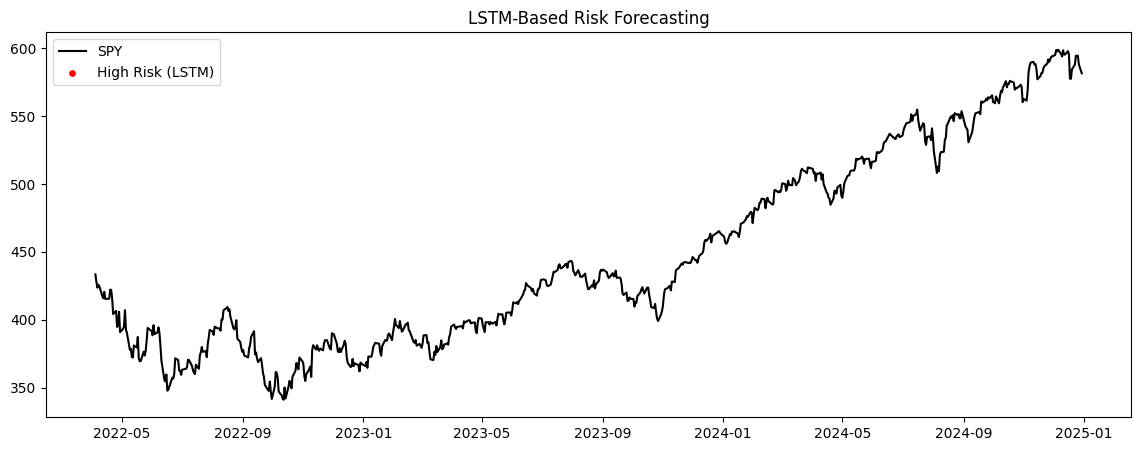

In [7]:
import matplotlib.pyplot as plt

prices = pd.read_csv(
    "../data/raw/prices.csv",
    index_col=0,
    parse_dates=True
)

spy = prices["SPY"].loc[preds.index]

plt.figure(figsize=(14,5))
plt.plot(spy, color="black", label="SPY")
plt.scatter(
    preds[preds > 0.6].index,
    spy.loc[preds[preds > 0.6].index],
    color="red",
    s=15,
    label="High Risk (LSTM)"
)
plt.legend()
plt.title("LSTM-Based Risk Forecasting")
plt.show()


In [8]:
preds.to_csv("../data/processed/lstm_risk_scores.csv")


In [9]:
threshold = preds.quantile(0.90)   # top 10% risk
